#**Astrofísica Moderna - Emisión de HI**

- **Sebastián Numpaque**

- **C. C. 1002396960**



---



#**Importe de Librerias**

In [ ]:
# @title
import numpy as np

import plotly.graph_objects as go

from scipy.optimize import curve_fit
from scipy.signal import find_peaks



---



#**Cargue de Datos**

- [1] Foster, T., & Routledge, D. (2001). The galactic plane region near l=93°. I. HII region NRAO 655. *Astronomy & Astrophysics, 367*(2), 635-651. https://doi.org/10.1051/0004-6361:20000432

In [ ]:
# @title
data = np.loadtxt('21cmsurvey_full.txt')

longs = data[0]
Ts_brightness = data[-1:0:-1].T
vs_LOS = np.loadtxt('vel.txt')[::-1]/1000



---



#**Gaussian Fit**

Definimos la función `gaussian_model(x, A, mu, sigma)` como perfil de ajuste.

$$f(x)=A\,e^{\frac{(x-\mu)^2}{2\sigma^2}}$$

- `x`: Variable Value $x$

- `A`: Amplitude $A$

- `mu`: Mean $\mu$

- `sigma`: Standard Deviation $\sigma$

Así mismo, declaramos la función `fit(range, vs, Ts)` que realiza el ajuste de de una sección de datos hacia un perfil gaussiano empleando la función `curve_fit` integrada al módulo `scipy.optimize` con el fin de encontrar los parámetros de ajuste ($A,\,\mu,\,\sigma$)

- `range`: Range of Data Values for Fitting

- `vs`: Values for Velocity

- `Ts`: Values for Temperature of Brightness



In [ ]:
# @title

# Gaussian Profile
gauss_model = lambda x, A, mu, sigma: A*np.exp(-(x - mu)**2/(2*sigma**2))

# Fitting Gaussian Profile to Data
def fit(range, vs = vs_LOS, Ts = Ts_brightness):

  # Data Range for Fitting
  fit_range = [(valley[i-1], valley[i])
              for T in Ts
              for j, k in [range]
              for valley in [find_peaks(-T)[0]]
              for i in [valley.searchsorted(j + T[j:k].argmax())]]

  # Getting Gaussian Parameters
  fit_parameters = [curve_fit(gauss_model, maxfev = 10000,
                              ydata = T[i:j], xdata = vs[i:j],
                              p0 = [T[i:j].max(),
                                    vs[i + T[i:j].argmax()], 1],
                              bounds = ([T[i:j].max()-5,
                                         vs[i+T[i:j].argmax()]-5, 0.5],
                                        [T[i:j].max()+5,
                                         vs[i+T[i:j].argmax()]+5, 10]))[0]

                      for (i,j), T in zip(fit_range, Ts)]

  return np.array(fit_parameters)



---



#**Mapping Distances**

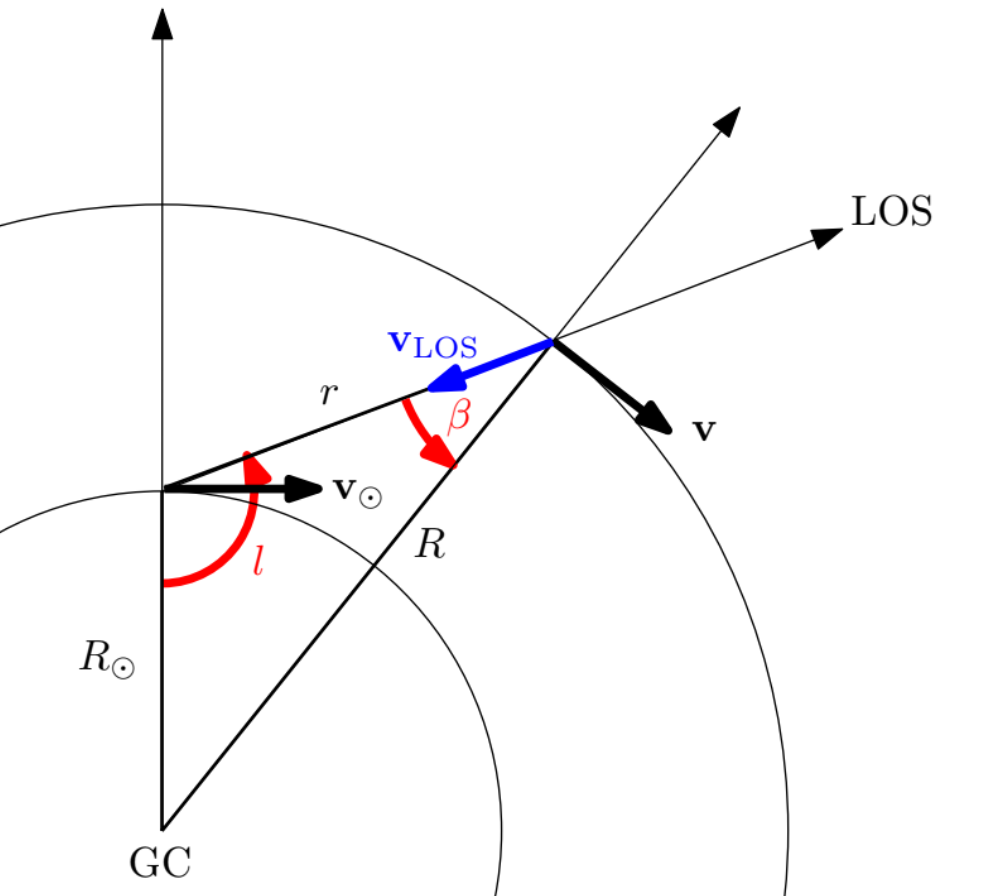

De acuerdo con la Figura presentada, establecemos las siguientes relaciones a partir del Teorema del Seno y Teorema del Coseno

$$\frac{R}{r}=\frac{\sin\ell}{\sin(\ell+\beta)}$$

$$r^2=R_\odot^2+R^2-2RR_\odot\cos(\pi-\ell-\beta)$$

A partir de un análisis mecánico, para un sistema galactocéntrico y rotante, encontramos la siguiente descripción de la separación angular

$$\pi-\ell-\beta = \omega t\quad;\qquad\omega=v_\odot\left(\frac{1}{R}-\frac{1}{R_\odot}\right)\quad\text{if}\quad v=v_\odot$$

Realizando la diferenciación de la separación entre la fuente de emisión es posible determinar la velociad de la fuente en dirección de la linea de visión

$$\begin{split}v_{_{LOS}}&=\frac{d}{dt}r\\&=\frac{v_\odot RR_\odot\sin(\ell + \beta)}{r}\left(\frac{1}{R}-\frac{1}{R_\odot}\right)\\
&=v_\odot R_\odot\sin\ell\left(\frac{1}{R}-\frac{1}{R_\odot}\right)\end{split}$$

De esta última expresión logramos obtener una relación para la distancia que tienen las estructuras de emisión hacia el centro de la galaxia.

$$\longrightarrow\quad R=R_\odot\frac{v_\odot\sin\ell}{v_{_{LOS}}+v_\odot\sin\ell}$$

In [ ]:
# @title

def R_func(l, v_LOS, R_sun = 8.3, v_sun = 225):

  return R_sun*v_sun*np.sin(l)/(v_LOS + v_sun*np.sin(l))



---



#**Fitting Perseus Arm Spectra**

Realizamos el ajuste del máximo de emisión en HI correspondiente a la emisión propia de la región del brazo de Perseo. Esto considerando el rango de velocidades de [-50 km/s, -15 km/s].

En secciones adelante discutiremos sobre la discrepancia obtenida respecto a las observaciones y sus estimaciones de una distancia de ~10 kpc para esta estructura dentro del campo de galaxia considerado (142° < $\ell$ < 147°)

In [ ]:
# @title

# Fitting Parameters for Perseus Arm
fit_perseus = fit(vs_LOS.searchsorted([-50,-15]))

mus, sigmas = fit_perseus[:,1:].T

# Distances Galaxy - Perseus Arm
Rs_perseus = R_func(longs*np.pi/180, mus)

# Confidence Interval
confidence_perseus = np.array([R_func(longs*np.pi/180, mus + 2*sigmas),
                               R_func(longs*np.pi/180, mus - 2*sigmas)])

<ipython-input-4-5541039cb1b5>:12: OptimizeWarning: Covariance of the parameters could not be estimated
  fit_parameters = [curve_fit(gauss_model, maxfev = 10000,




---



#**Fitting Outer Arm Espectra**

Realizamos el ajuste del máximo de emisión en HI dentro del rango de velocidades [-60 km/s, -55 km/s] correspondiente a la emisión propia de la región del brazo exterior.

Escogemos este rango de velocidades tomando en consideración los resultados de Verschuur, G. (1973) [1]. A continuación observaremos que dentro de esta región se resaltan máximos de emisión importantes que se ajustan con las estimaciones de una distancia ~14 kpc dentro del campo de galaxia considerado (142° < $\ell$ < 147°)

- [1] Verschuur, G. L. (1973). The Perseus Spiral Arm at 21-cm. *Astronomy & Astrophysics, 24*, 193. https://ui.adsabs.harvard.edu/abs/1973A&A....24..193V

In [ ]:
# @title

# Fitting Parameters for Outer Arm
fit_outer = fit(vs_LOS.searchsorted([-60,-55]))

mus, sigmas = fit_outer[:,1:].T

# Distances Galaxy - Outer Arm
Rs_outer = R_func(longs*np.pi/180, mus)

# Confidence Interval
confidence_outer = np.array([R_func(longs*np.pi/180, mus + 2*sigmas),
                             R_func(longs*np.pi/180, mus - 2*sigmas)])

<ipython-input-4-5541039cb1b5>:12: OptimizeWarning: Covariance of the parameters could not be estimated
  fit_parameters = [curve_fit(gauss_model, maxfev = 10000,




---



#**Plotting Emission Fitting**

In [ ]:
#@markdown Maximum Latitude

go.Figure([go.Scatter(x = vs_LOS,
                      y = Ts_brightness[0],
                      showlegend = False),
           go.Scatter(x = vs_LOS,
                      y = gauss_model(vs_LOS, *fit_perseus[0]),
                      name = 'Perseus Arm'),
           go.Scatter(x = vs_LOS,
                      y = gauss_model(vs_LOS, *fit_outer[0]),
                      name = 'Outer Arm')],

          layout = go.Layout(width = 900, height = 600,
                             title_text = 'Galaxy HI Emission Line'+\
                                          f'<br>(l = {longs[0]:.2f}°)',
                             title_x = 0.5, title_y = 0.94,
                             xaxis_title = 'Velocity [km/s]',
                             yaxis_title = 'Brightness Temperature [K]',
                             legend = dict(orientation = 'h',
                                           x = 0.65, y = 1.07,
                                           bgcolor = 'rgba(0,0,0,0)')))

In [ ]:
#@markdown Medium Latitude

N = len(longs)

go.Figure([go.Scatter(x = vs_LOS,
                      y = Ts_brightness[N//2 + 5],
                      showlegend = False),
           go.Scatter(x = vs_LOS,
                      y = gauss_model(vs_LOS, *fit_perseus[N//2 + 5]),
                      name = 'Perseus Arm'),
           go.Scatter(x = vs_LOS,
                      y = gauss_model(vs_LOS, *fit_outer[N//2 + 5]),
                      name = 'Outer Arm')],

          layout = go.Layout(width = 900, height = 600,
                             title_text = 'Galaxy HI Emission Line'+\
                                          f'<br>(l = {longs[N//2 + 5]:.2f}°)',
                             title_x = 0.5, title_y = 0.94,
                             xaxis_title = 'Velocity [km/s]',
                             yaxis_title = 'Brightness Temperature [K]',
                             legend = dict(orientation = 'h',
                                           x = 0.65, y = 1.07,
                                           bgcolor = 'rgba(0,0,0,0)')))

In [ ]:

#@markdown Minimum Latitude
go.Figure([go.Scatter(x = vs_LOS,
                      y = Ts_brightness[-5],
                      showlegend = False),
           go.Scatter(x = vs_LOS,
                      y = gauss_model(vs_LOS, *fit_perseus[-5]),
                      name = 'Perseus Arm'),
           go.Scatter(x = vs_LOS,
                      y = gauss_model(vs_LOS, *fit_outer[-5]),
                      name = 'Outer Arm')],

          layout = go.Layout(width = 900, height = 600,
                             title_text = 'Galaxy HI Emission Line'+\
                                          f'<br>(l = {longs[-5]:.2f}°)',
                             title_x = 0.5, title_y = 0.94,
                             xaxis_title = 'Velocity [km/s]',
                             yaxis_title = 'Brightness Temperature [K]',
                             legend = dict(orientation = 'h',
                                           x = 0.65, y = 1.07,
                                           bgcolor = 'rgba(0,0,0,0)')))



---



A partir de los ajutes realizados sobre los espectros de emisión, donde determinamos la velocidad que tienen estas estructuras en dirección de la linea de visión, reconstruimos la morfología de los brazos de Perseo y Exterior de la galaxia.

Notamos que en general, el método efectuado tiene un sesgo de ~2 kpc en la sobre-estimación de distancias considerando que el radio estimado de la galaxia es ~16 kpc. Aún así, podemos apreciar ciertos insights sobre la morfología de dos brazos que son fuente de emisión en HI dentro de esta región comprendida de la galaxia (142° < $\ell$ < 147°).

Para mejorar la aproximación en la determinación de la estructura de la galaxia se podría complementar la estimación de distancias mediante el ánalisis de poblaciones estelares jovenes y sus sobre-densidades.

Sobre los intervalos de confianza establecidos, sería más apropiado un ancho de 1$\sigma$ para no sobrepasar el tamaño real de la galaxia y reducir la extensión real de las estructuras. No hay conflicto estadistico con ello, teniendo en cuenta que los ajustes gaussianos son de baja varianza y por tanto la dispersión de velocidades no es alta.

In [ ]:
#@markdown Plotting Galaxy Spiral Arms

go.Figure(data = [go.Scatter(x = longs, y = Rs_perseus,
                             mode = 'markers',
                             name = 'Perseus Arm'),
                  go.Scatter(x = np.append(longs, longs[::-1]),
                             y = np.append(confidence_perseus[0],
                                           confidence_perseus[1][::-1]),
                             fill = 'toself',
                             marker_color = 'rgba(68, 68, 68, 0.3)',
                             fillcolor = 'rgba(68, 68, 68, 0.3)',
                             showlegend=False),
                  go.Scatter(x = longs, y = Rs_outer,
                             mode = 'markers',
                             name = 'Outer Arm'),
                  go.Scatter(x = np.append(longs, longs[::-1]),
                             y = np.append(confidence_outer[0],
                                           confidence_outer[1][::-1]),
                             marker_color = 'rgba(68, 68, 68, 0.3)',
                             fill = 'toself',
                             fillcolor = 'rgba(68, 68, 68, 0.3)',
                             showlegend=False),],

          layout = go.Layout(height = 600, width = 900,
                             title_x = 0.5, title_y = 0.94,
                             xaxis_title = 'Galactic Longitude [°]',
                             yaxis_title = 'R [kpc]',
                             yaxis_range = [9.5, 19],
                             xaxis_range = [147.5, 142],
                             title_text = 'Galaxy Spiral Arms',
                             legend = dict(orientation = 'h',
                                           x = 0.65, y = 1.07,
                                           bgcolor = 'rgba(0,0,0,0)')))